In [306]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [190]:
# CONSTANTS
FEATURE_1 = 'X1'
FEATURE_2 = 'X2'
CLASS_LABEL_COLUMN_NAME = 'Y'
COLUMN_NAMES = [FEATURE_1, FEATURE_2, CLASS_LABEL_COLUMN_NAME] # Assumption is all text files have only 2 features 
_id = 0

In [191]:
# Decision Tree Node where 'left' is the 'then' branch & 'right' is the 'else' branch of the parent 'predicate'
# If node is a 'leaf', then 'label' is set to the class label, else 'predicate' contains the predicate in string format
# '_id' represents the node id which is unique for each node. 'parent_link' comprises of the parent _id followed by 
# _left or _right indicating if the node is a left child or right child
class d3Node:
    def __init__(self, left, right, leaf, label, predicate, parent_link, feature, split_val):
        global _id
        self.left = left
        self.right = right
        self.leaf = leaf
        self.label = label
        self.predicate = predicate
        self._id = _id + 1
        self.parent_link = parent_link
        self.feature = feature
        self.split_val = split_val
        _id = _id + 1

In [192]:
def read_csv(file_name, column_names):
    return pd.read_csv(file_name, sep=' ', header=None, names=column_names)

In [193]:
# Tries all possible numbers in feature as potential split values
def determine_best_split_entropy_and_gain_ratio(dataset, feature_column, debug = False):
    print("Searching best split candidate for: " + str(feature_column))
    best_split = None
    max_entropy = None
    max_gain_ratio = None
    class_entropy = calculate_class_entropy(dataset)
    for split in dataset[feature_column]:
        conditional_entropy, feature_entropy = calculate_conditional_and_feature_entropy(dataset, feature_column, split)
        gain = class_entropy - conditional_entropy
        if feature_entropy == 0:
            gain_ratio = 0
        else:
            gain_ratio = gain/feature_entropy
        if best_split is None or gain_ratio > max_gain_ratio:
            best_split = split
            max_gain_ratio = gain_ratio
            max_entropy = conditional_entropy
        if debug == True:
            print("Split: " + str(split) + ", Gain Ratio: " + str(gain_ratio) + ", Information Gain: " + str(conditional_entropy))
    return best_split, max_entropy, max_gain_ratio

In [194]:
def calculate_class_entropy(dataset):
    positive_count = len(dataset[dataset[CLASS_LABEL_COLUMN_NAME] == 1])
    negative_count = len(dataset[dataset[CLASS_LABEL_COLUMN_NAME] == 0])
    return calculate_entropy(positive_count, negative_count, len(dataset))

In [195]:
def calculate_conditional_and_feature_entropy(dataset, feature_column, split_value):
    # predicate: dataset[featureColumn] >= splitValue
    else_dataset = dataset[dataset[feature_column] < split_value]
    else_positive_count = len(else_dataset[dataset[CLASS_LABEL_COLUMN_NAME] == 1])
    then_dataset = dataset[dataset[feature_column] >= split_value]
    then_positive_count = len(then_dataset[dataset[CLASS_LABEL_COLUMN_NAME] == 1])
    else_entropy = calculate_entropy(else_positive_count, len(else_dataset)-else_positive_count, len(else_dataset))
    then_entropy = calculate_entropy(then_positive_count, len(then_dataset)-then_positive_count, len(then_dataset))
    conditional_entropy = (len(else_dataset)/len(dataset)) * else_entropy + (len(then_dataset)/len(dataset)) * then_entropy
    feature_entropy = calculate_entropy(len(then_dataset), len(else_dataset), len(dataset))
    return conditional_entropy, feature_entropy

In [196]:
def calculate_entropy(pos_count, neg_count, total_count):
    if pos_count == 0 or neg_count == 0:
        return 0
    return -1 * ((pos_count/total_count) * math.log(pos_count/total_count, 2) + (neg_count/total_count) * math.log(neg_count/total_count, 2))

In [197]:
def predict_majority_class(dataset):
    positive_count = len(dataset[dataset[CLASS_LABEL_COLUMN_NAME] == 1])
    negative_count = len(dataset[dataset[CLASS_LABEL_COLUMN_NAME] == 0])
    return 1 if positive_count >= negative_count else 0

In [198]:
def split_node_on(feature_name, dataset, split):
    leftDataset = dataset[dataset[feature_name] >= split]
    rightDataset = dataset[dataset[feature_name] < split]
    predicate = str(feature_name) + " >= " + str(split)
    return leftDataset, rightDataset, predicate

In [199]:
def generate_d3(dataset, parent_link):
    X1_split, X1_entropy, X1_gain_ratio = determine_best_split_entropy_and_gain_ratio(dataset, FEATURE_1)
    print("Best X1_split: " + str(X1_split) + ", X1_entropy: " + str(X1_entropy) + ", X1_gain_ratio: " + str(X1_gain_ratio))
    X2_split, X2_entropy, X2_gain_ratio = determine_best_split_entropy_and_gain_ratio(dataset, FEATURE_2)
    print("Best X2_split: " + str(X2_split) + ", X2_entropy: " + str(X2_entropy) + ", X2_gain_ratio: " + str(X2_gain_ratio))

    # stopping criteria
    if len(dataset) == 0:
        print("Dataset size is 0... Stopping")
        return d3Node(None, None, True, 1, "", parent_link, None, None)
    elif X1_gain_ratio == 0 and X2_gain_ratio == 0:
        print("X1 and X2 gain ratio is 0. Finding majority class and stopping")
        return d3Node(None, None, True, predict_majority_class(dataset), "", parent_link, None, None)
    else:
        if X1_gain_ratio > X2_gain_ratio:
            print("X1_gain_ratio > X2_gain_ratio. Choosing X1 as split feature...")
            leftDataset, rightDataset, predicate = split_node_on(FEATURE_1, dataset, X1_split)
            node = d3Node(None, None, False, None, predicate, parent_link, FEATURE_1, X1_split)
            leftNode = generate_d3(leftDataset, str(node._id) + "_left")
            rightNode = generate_d3(rightDataset, str(node._id) + "_right")
            node.left = leftNode
            node.right = rightNode
            return node
        else:
            print("X2_gain_ratio > X1_gain_ratio. Choosing X2 as split feature...")
            leftDataset, rightDataset, predicate = split_node_on(FEATURE_2, dataset, X2_split)
            node = d3Node(None, None, False, None, predicate, parent_link, FEATURE_2, X2_split)
            leftNode = generate_d3(leftDataset, str(node._id) + "_left")
            rightNode = generate_d3(rightDataset, str(node._id) + "_right")
            node.left = leftNode
            node.right = rightNode
            return node

In [200]:
def print_node(node):
    if node.leaf is True:
        print("[Id: " + str(node._id) + ", label: " + str(node.label) + ", parent: " + str(node.parent_link) + "]", end = " ")
    else:
        print("[Id: " + str(node._id) + ", predicate: " + str(node.predicate) + ", parent: " + str(node.parent_link) + "]", end = " ")

In [345]:
# Tree is printed one level at a time. 
def printD3(d3_node):
    level = []
    level_no = 0
    level.append(d3_node)
    print("Level: " + str(level_no))
    while(len(level) > 0):
        nextLevel = []
        while(len(level) > 0):
            node = level.pop(0)
            print_node(node)
            if node.left is not None:
                nextLevel.append(node.left)
            if node.right is not None:
                nextLevel.append(node.right)
        level = nextLevel
        level_no = level_no + 1
        print("")
        if len(level) > 0:
            print("Level: " + str(level_no))

In [202]:
def print_boolean_expression(label, predicates):
    result = ""
    for pred in predicates:
        if len(result) == 0:
            result = result + pred
        else:
            result = result + " and " + pred
    result = result + " == " + str(label)
    print(result)

In [203]:
def fetch_boolean_expressions(node, boolean_stack):
    left_stack = boolean_stack.copy()
    right_stack = boolean_stack.copy()
    if node.leaf is False:
        if node.left is not None:
            left_stack.append(node.predicate)
            fetch_boolean_expressions(node.left, left_stack)
        if node.right is not None:
            right_stack.append("!(" + node.predicate + ")")
            fetch_boolean_expressions(node.right, right_stack)
    else:
        print_boolean_expression(node.label, boolean_stack)

In [204]:
def computeTestError(dataset, d3_node):
    result = dataset.copy()
    result['P'] = result.apply(lambda row: predict(d3_node, row[FEATURE_1], row[FEATURE_2]), axis=1)
    result['error'] = pd.Series.abs(result['Y'] - result['P'])
    error = result['error'].sum() / len(result)
    return error

In [205]:
def scatter_plot(dataset):
    dataset.plot(kind = 'scatter', x = 'X1', y = 'X2')

In [206]:
def predict(d3_node, x1, x2):
    node = d3_node
    while(node.leaf == False):
        if node.feature == FEATURE_1:
            if x1 >= node.split_val:
                node = node.left
            else:
                node = node.right
        else:
            if x2 >= node.split_val:
                node = node.left
            else:
                node = node.right
    return node.label

In [301]:
def decision_boundary(dataset, d3_node, X1_lines, X2_lines):
    result = dataset.copy()
    result['P'] = result.apply(lambda row: predict(d3_node, row[FEATURE_1], row[FEATURE_2]), axis=1)
    result.plot(kind = 'scatter', x = 'X1', y = 'X2', c = result['P'].apply(lambda p: 'red' if p == 1 else 'blue'))

In [330]:
def plot_decision_boundary(dataset, d3_node, X1_lines, X2_lines):
    result = dataset.copy()
    result['P'] = result.apply(lambda row: predict(d3_node, row[FEATURE_1], row[FEATURE_2]), axis=1)
    fig, ax = plt.subplots()
    [ax.axhline(y=i, linestyle='-') for i in X2_lines]
    [ax.axvline(x=i, linestyle='-') for i in X1_lines]
    [ax.scatter(x = result[FEATURE_1], y = result[FEATURE_2], c = result['P'].apply(lambda p: 'red' if p == 1 else 'blue') )]

In [295]:
def fetch_decision_lines(d3_node):
    X1=[]
    X2=[]
    level = []
    level.append(d3_node)
    while(len(level) > 0):
        nextLevel = []
        while(len(level) > 0):
            node = level.pop(0)
            if node.leaf is False:
                if node.feature == FEATURE_1:
                    X1.append(node.split_val)
                else:
                    X2.append(node.split_val)
            if node.left is not None:
                nextLevel.append(node.left)
            if node.right is not None:
                nextLevel.append(node.right)
        level = nextLevel
    return X1, X2

In [359]:
def get_number_of_nodes(root):
    count = 0
    level = []
    level.append(root)
    count = count + 1
    while(len(level) > 0):
        nextLevel = []
        while(len(level) > 0):
            node = level.pop(0)
            if node.left is not None:
                nextLevel.append(node.left)
                count = count + 1
            if node.right is not None:
                nextLevel.append(node.right)
                count = count + 1
        level = nextLevel
    return count

In [208]:
# Q6

In [209]:
# D1.txt

In [210]:
D1_dataset = read_csv(file_name = 'D1.txt', column_names = COLUMN_NAMES)

In [211]:
global _id
_id = 0
d3_root_D1 = generate_d3(D1_dataset, "root")

Searching best split candidate for: X1


/var/folders/v0/g401c4x979d___jdl5ddw2_r0000gn/T/ipykernel_36454/1135821344.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  else_positive_count = len(else_dataset[dataset[CLASS_LABEL_COLUMN_NAME] == 1])
/var/folders/v0/g401c4x979d___jdl5ddw2_r0000gn/T/ipykernel_36454/1135821344.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  then_positive_count = len(then_dataset[dataset[CLASS_LABEL_COLUMN_NAME] == 1])


Best X1_split: 0.011643, X1_entropy: 0.6651000555777548, X1_gain_ratio: 0.03684617862751271
Searching best split candidate for: X2
Best X2_split: 0.201829, X2_entropy: 0.0, X2_gain_ratio: 1.0
X2_gain_ratio > X1_gain_ratio. Choosing X2 as split feature...
Searching best split candidate for: X1
Best X1_split: 0.409499, X1_entropy: 0.0, X1_gain_ratio: 0.0
Searching best split candidate for: X2
Best X2_split: 0.213456, X2_entropy: 0.0, X2_gain_ratio: 0.0
X1 and X2 gain ratio is 0. Finding majority class and stopping
Searching best split candidate for: X1
Best X1_split: 0.264185, X1_entropy: 0.0, X1_gain_ratio: 0.0
Searching best split candidate for: X2
Best X2_split: 0.178456, X2_entropy: 0.0, X2_gain_ratio: 0.0
X1 and X2 gain ratio is 0. Finding majority class and stopping


In [346]:
printD3(d3_root_D1)

Level: 0
[Id: 1, predicate: X2 >= 0.201829, parent: root] 
Level: 1
[Id: 2, label: 1, parent: 1_left] [Id: 3, label: 0, parent: 1_right] 


In [213]:
fetch_boolean_expressions(d3_root_D1, [])

X2 >= 0.201829 == 1
!(X2 >= 0.201829) == 0


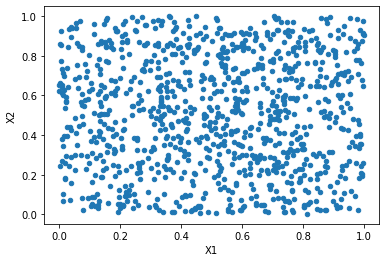

In [324]:
scatter_plot(D1_dataset)

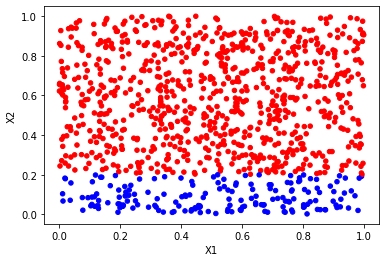

In [215]:
decision_boundary(D1_dataset, d3_root_D1)

In [296]:
X1_lines, X2_lines = fetch_decision_lines(d3_root_D1)

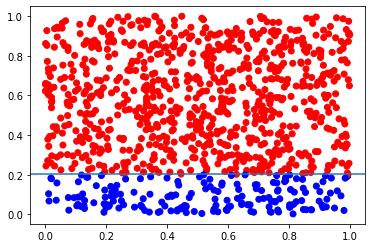

In [332]:
plot_decision_boundary(D1_dataset, d3_root_D1, X1_lines, X2_lines)

In [216]:
# D2.txt

In [217]:
D2_dataset = read_csv(file_name = 'D2.txt', column_names = COLUMN_NAMES)

In [218]:
global _id
_id = 0
d3_root_D2 = generate_d3(D2_dataset, "root")

Searching best split candidate for: X1


/var/folders/v0/g401c4x979d___jdl5ddw2_r0000gn/T/ipykernel_36454/1135821344.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  else_positive_count = len(else_dataset[dataset[CLASS_LABEL_COLUMN_NAME] == 1])
/var/folders/v0/g401c4x979d___jdl5ddw2_r0000gn/T/ipykernel_36454/1135821344.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  then_positive_count = len(then_dataset[dataset[CLASS_LABEL_COLUMN_NAME] == 1])


Best X1_split: 0.533076, X1_entropy: 0.7762423911525194, X1_gain_ratio: 0.22380611436687328
Searching best split candidate for: X2
Best X2_split: 0.919236, X2_entropy: 0.9196801848089097, X2_gain_ratio: 0.21050713301313584
X1_gain_ratio > X2_gain_ratio. Choosing X1 as split feature...
Searching best split candidate for: X1
Best X1_split: 0.73682, X1_entropy: 0.6999247582322485, X1_gain_ratio: 0.07298119048863273
Searching best split candidate for: X2
Best X2_split: 0.228007, X2_entropy: 0.452447274679619, X2_gain_ratio: 0.40277675382774364
X2_gain_ratio > X1_gain_ratio. Choosing X2 as split feature...
Searching best split candidate for: X1
Best X1_split: 0.708127, X1_entropy: 0.240672151271365, X1_gain_ratio: 0.10384657152104462
Searching best split candidate for: X2
Best X2_split: 0.424906, X2_entropy: 0.19927363279759924, X2_gain_ratio: 0.1751133281825154
X2_gain_ratio > X1_gain_ratio. Choosing X2 as split feature...
Searching best split candidate for: X1
Best X1_split: 0.985903, X1_

Best X2_split: 0.88635, X2_entropy: 0.5434080314486995, X2_gain_ratio: 0.4582140527187489
X2_gain_ratio > X1_gain_ratio. Choosing X2 as split feature...
Searching best split candidate for: X1
Best X1_split: 0.041245, X1_entropy: 0.21002015174930602, X1_gain_ratio: 0.6245466344128493
Searching best split candidate for: X2
Best X2_split: 0.91985, X2_entropy: 0.20328010157213344, X2_gain_ratio: 0.09051206861828238
X1_gain_ratio > X2_gain_ratio. Choosing X1 as split feature...
Searching best split candidate for: X1
Best X1_split: 0.104043, X1_entropy: 0.09338601702249047, X1_gain_ratio: 0.2533887517364727
Searching best split candidate for: X2
Best X2_split: 0.91985, X2_entropy: 0.15633482125715853, X2_gain_ratio: 0.0631439283799352
X1_gain_ratio > X2_gain_ratio. Choosing X1 as split feature...
Searching best split candidate for: X1
Best X1_split: 0.315561, X1_entropy: 0.0, X1_gain_ratio: 0.0
Searching best split candidate for: X2
Best X2_split: 0.956006, X2_entropy: 0.0, X2_gain_ratio: 0.

Best X2_split: 0.549961, X2_entropy: 0.0, X2_gain_ratio: 0
X1 and X2 gain ratio is 0. Finding majority class and stopping
Searching best split candidate for: X1
Best X1_split: 0.347109, X1_entropy: 0.0, X1_gain_ratio: 0.0
Searching best split candidate for: X2
Best X2_split: 0.56674, X2_entropy: 0.0, X2_gain_ratio: 0.0
X1 and X2 gain ratio is 0. Finding majority class and stopping
Searching best split candidate for: X1
Best X1_split: 0.401686, X1_entropy: 0.0, X1_gain_ratio: 0.0
Searching best split candidate for: X2
Best X2_split: 0.431972, X2_entropy: 0.0, X2_gain_ratio: 0.0
X1 and X2 gain ratio is 0. Finding majority class and stopping


In [347]:
printD3(d3_root_D2)

Level: 0
[Id: 1, predicate: X1 >= 0.533076, parent: root] 
Level: 1
[Id: 2, predicate: X2 >= 0.228007, parent: 1_left] [Id: 29, predicate: X2 >= 0.88635, parent: 1_right] 
Level: 2
[Id: 3, predicate: X2 >= 0.424906, parent: 2_left] [Id: 16, predicate: X1 >= 0.887224, parent: 2_right] [Id: 30, predicate: X1 >= 0.041245, parent: 29_left] [Id: 37, predicate: X2 >= 0.691474, parent: 29_right] 
Level: 3
[Id: 4, label: 1, parent: 3_left] [Id: 5, predicate: X1 >= 0.708127, parent: 3_right] [Id: 17, predicate: X2 >= 0.037708, parent: 16_left] [Id: 24, predicate: X1 >= 0.850316, parent: 16_right] [Id: 31, predicate: X1 >= 0.104043, parent: 30_left] [Id: 36, label: 0, parent: 30_right] [Id: 38, predicate: X1 >= 0.254049, parent: 37_left] [Id: 49, predicate: X2 >= 0.534979, parent: 37_right] 
Level: 4
[Id: 6, label: 1, parent: 5_left] [Id: 7, predicate: X2 >= 0.32625, parent: 5_right] [Id: 18, predicate: X2 >= 0.082895, parent: 17_left] [Id: 23, label: 0, parent: 17_right] [Id: 25, predicate: X2 

In [220]:
fetch_boolean_expressions(d3_root_D2, [])

X1 >= 0.533076 and X2 >= 0.228007 and X2 >= 0.424906 == 1
X1 >= 0.533076 and X2 >= 0.228007 and !(X2 >= 0.424906) and X1 >= 0.708127 == 1
X1 >= 0.533076 and X2 >= 0.228007 and !(X2 >= 0.424906) and !(X1 >= 0.708127) and X2 >= 0.32625 and X1 >= 0.595471 and X1 >= 0.646007 == 1
X1 >= 0.533076 and X2 >= 0.228007 and !(X2 >= 0.424906) and !(X1 >= 0.708127) and X2 >= 0.32625 and X1 >= 0.595471 and !(X1 >= 0.646007) and X2 >= 0.403494 == 1
X1 >= 0.533076 and X2 >= 0.228007 and !(X2 >= 0.424906) and !(X1 >= 0.708127) and X2 >= 0.32625 and X1 >= 0.595471 and !(X1 >= 0.646007) and !(X2 >= 0.403494) == 0
X1 >= 0.533076 and X2 >= 0.228007 and !(X2 >= 0.424906) and !(X1 >= 0.708127) and X2 >= 0.32625 and !(X1 >= 0.595471) == 0
X1 >= 0.533076 and X2 >= 0.228007 and !(X2 >= 0.424906) and !(X1 >= 0.708127) and !(X2 >= 0.32625) == 0
X1 >= 0.533076 and !(X2 >= 0.228007) and X1 >= 0.887224 and X2 >= 0.037708 and X2 >= 0.082895 == 1
X1 >= 0.533076 and !(X2 >= 0.228007) and X1 >= 0.887224 and X2 >= 0.0377

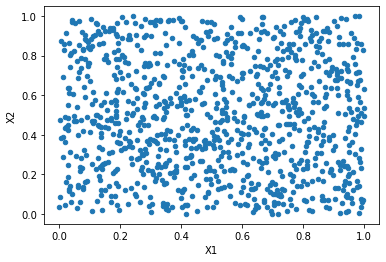

In [222]:
scatter_plot(D2_dataset)

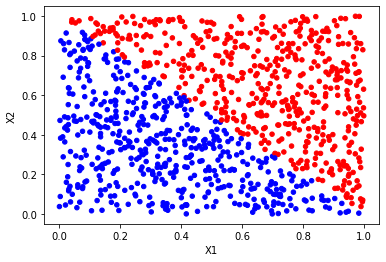

In [223]:
decision_boundary(D2_dataset, d3_root_D2)

In [334]:
X1_lines, X2_lines = fetch_decision_lines(d3_root_D2)

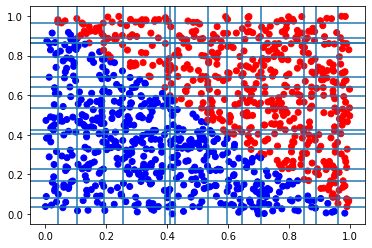

In [335]:
plot_decision_boundary(D2_dataset, d3_root_D2, X1_lines, X2_lines)

In [224]:
# Q3

In [225]:
Druns_dataset = read_csv(file_name = 'Druns.txt', column_names = COLUMN_NAMES)

In [226]:
Druns_dataset

,X1,X2,Y
0,0.1,-2,0
1,0.0,-1,1
2,0.0,0,0
3,0.0,1,0
4,0.0,2,0
5,0.0,3,0
6,0.0,4,0
7,0.0,5,0
8,0.0,6,1
9,0.0,7,0


<AxesSubplot:xlabel='X1', ylabel='X2'>

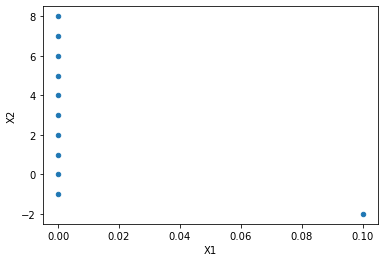

In [227]:
Druns_dataset.plot(kind = 'scatter', x = 'X1', y = 'X2')

<AxesSubplot:xlabel='X1', ylabel='X2'>

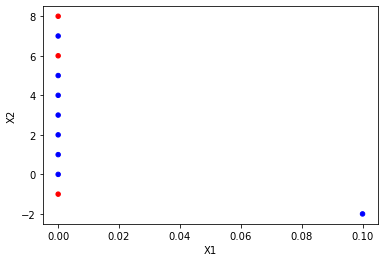

In [228]:
Druns_dataset.plot(kind = 'scatter', x = 'X1', y = 'X2', c = Druns_dataset['Y'].apply(lambda y: 'red' if y == 1 else 'blue'))

In [229]:
determine_best_split_conditional_entropy_and_gain_ratio(Druns_dataset, FEATURE_1, True)

Searching best split candidate for: X1
Split: 0.1, Gain Ratio: 0.10051807676021852, Information Gain: 0.04417739186726144
Split: 0.0, Gain Ratio: 0, Information Gain: 0.0
Split: 0.0, Gain Ratio: 0, Information Gain: 0.0
Split: 0.0, Gain Ratio: 0, Information Gain: 0.0
Split: 0.0, Gain Ratio: 0, Information Gain: 0.0
Split: 0.0, Gain Ratio: 0, Information Gain: 0.0
Split: 0.0, Gain Ratio: 0, Information Gain: 0.0
Split: 0.0, Gain Ratio: 0, Information Gain: 0.0
Split: 0.0, Gain Ratio: 0, Information Gain: 0.0
Split: 0.0, Gain Ratio: 0, Information Gain: 0.0
Split: 0.0, Gain Ratio: 0, Information Gain: 0.0


/var/folders/v0/g401c4x979d___jdl5ddw2_r0000gn/T/ipykernel_36454/1135821344.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  else_positive_count = len(else_dataset[dataset[CLASS_LABEL_COLUMN_NAME] == 1])
/var/folders/v0/g401c4x979d___jdl5ddw2_r0000gn/T/ipykernel_36454/1135821344.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  then_positive_count = len(then_dataset[dataset[CLASS_LABEL_COLUMN_NAME] == 1])


(0.1, 0.8011735447551751, 0.10051807676021852)

In [230]:
determine_best_split_conditional_entropy_and_gain_ratio(Druns_dataset, FEATURE_2, True)

Searching best split candidate for: X2
Split: -2, Gain Ratio: 0, Information Gain: 0.0
Split: -1, Gain Ratio: 0.10051807676021852, Information Gain: 0.04417739186726144
Split: 0, Gain Ratio: 0.055953759631263686, Information Gain: 0.03827452220629257
Split: 1, Gain Ratio: 0.005780042205152451, Information Gain: 0.004886164091842837
Split: 2, Gain Ratio: 0.0011443495172768668, Information Gain: 0.0010821659130776373
Split: 3, Gain Ratio: 0.016411136842102245, Information Gain: 0.016313165825732168
Split: 4, Gain Ratio: 0.04974906418177866, Information Gain: 0.04945207278939412
Split: 5, Gain Ratio: 0.1112402958633981, Information Gain: 0.1051955320700464
Split: 6, Gain Ratio: 0.2360996061436081, Information Gain: 0.19958702318968746
Split: 7, Gain Ratio: 0.055953759631263686, Information Gain: 0.03827452220629257
Split: 8, Gain Ratio: 0.43015691613098095, Information Gain: 0.18905266854301628


/var/folders/v0/g401c4x979d___jdl5ddw2_r0000gn/T/ipykernel_36454/1135821344.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  else_positive_count = len(else_dataset[dataset[CLASS_LABEL_COLUMN_NAME] == 1])
/var/folders/v0/g401c4x979d___jdl5ddw2_r0000gn/T/ipykernel_36454/1135821344.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  then_positive_count = len(then_dataset[dataset[CLASS_LABEL_COLUMN_NAME] == 1])


(8, 0.6562982680794203, 0.43015691613098095)

In [231]:
global _id
_id = 0
druns_dt = generate_d3(Druns_dataset, 'root')

Searching best split candidate for: X1
Best X1_split: 0.1, X1_entropy: 0.8011735447551751, X1_gain_ratio: 0.10051807676021852
Searching best split candidate for: X2


/var/folders/v0/g401c4x979d___jdl5ddw2_r0000gn/T/ipykernel_36454/1135821344.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  else_positive_count = len(else_dataset[dataset[CLASS_LABEL_COLUMN_NAME] == 1])
/var/folders/v0/g401c4x979d___jdl5ddw2_r0000gn/T/ipykernel_36454/1135821344.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  then_positive_count = len(then_dataset[dataset[CLASS_LABEL_COLUMN_NAME] == 1])


Best X2_split: 8, X2_entropy: 0.6562982680794203, X2_gain_ratio: 0.43015691613098095
X2_gain_ratio > X1_gain_ratio. Choosing X2 as split feature...
Searching best split candidate for: X1
Best X1_split: 0.0, X1_entropy: 0.0, X1_gain_ratio: 0
Searching best split candidate for: X2
Best X2_split: 8, X2_entropy: 0.0, X2_gain_ratio: 0
X1 and X2 gain ratio is 0. Finding majority class and stopping
Searching best split candidate for: X1
Best X1_split: 0.1, X1_entropy: 0.6877840558577583, X1_gain_ratio: 0.07280247297910734
Searching best split candidate for: X2
Best X2_split: 0, X2_entropy: 0.6348515545596771, X2_gain_ratio: 0.1206166388929235
X2_gain_ratio > X1_gain_ratio. Choosing X2 as split feature...
Searching best split candidate for: X1
Best X1_split: 0.0, X1_entropy: 0.5435644431995964, X1_gain_ratio: 0
Searching best split candidate for: X2
Best X2_split: 6, X2_entropy: 0.25, X2_gain_ratio: 0.36185425731195636
X2_gain_ratio > X1_gain_ratio. Choosing X2 as split feature...
Searching be

In [348]:
printD3(druns_dt)

Level: 0
[Id: 1, predicate: X2 >= 8, parent: root] 
Level: 1
[Id: 2, label: 1, parent: 1_left] [Id: 3, predicate: X2 >= 0, parent: 1_right] 
Level: 2
[Id: 4, predicate: X2 >= 6, parent: 3_left] [Id: 9, predicate: X2 >= -1, parent: 3_right] 
Level: 3
[Id: 5, predicate: X2 >= 7, parent: 4_left] [Id: 8, label: 0, parent: 4_right] [Id: 10, label: 1, parent: 9_left] [Id: 11, label: 0, parent: 9_right] 
Level: 4
[Id: 6, label: 0, parent: 5_left] [Id: 7, label: 1, parent: 5_right] 


In [233]:
fetch_boolean_expressions(druns_dt, [])

X2 >= 8 == 1
!(X2 >= 8) and X2 >= 0 and X2 >= 6 and X2 >= 7 == 0
!(X2 >= 8) and X2 >= 0 and X2 >= 6 and !(X2 >= 7) == 1
!(X2 >= 8) and X2 >= 0 and !(X2 >= 6) == 0
!(X2 >= 8) and !(X2 >= 0) and X2 >= -1 == 1
!(X2 >= 8) and !(X2 >= 0) and !(X2 >= -1) == 0


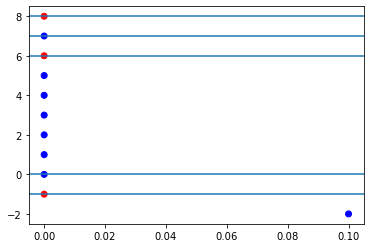

In [336]:
X1_lines, X2_lines = fetch_decision_lines(druns_dt)

plot_decision_boundary(Druns_dataset, druns_dt, X1_lines, X2_lines)

In [234]:
#Q2

In [235]:
data = [[1,0,1],[0,1,1],[1,1,0],[0,0,0]]

In [236]:
df = pd.DataFrame(data, columns=['X1','X2','Y'])

In [237]:
df

,X1,X2,Y
0,1,0,1
1,0,1,1
2,1,1,0
3,0,0,0


In [238]:
q2_d3 = generate_d3(df, 'root')

Searching best split candidate for: X1
Best X1_split: 1, X1_entropy: 1.0, X1_gain_ratio: 0.0
Searching best split candidate for: X2
Best X2_split: 0, X2_entropy: 1.0, X2_gain_ratio: 0
X1 and X2 gain ratio is 0. Finding majority class and stopping


/var/folders/v0/g401c4x979d___jdl5ddw2_r0000gn/T/ipykernel_36454/1135821344.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  else_positive_count = len(else_dataset[dataset[CLASS_LABEL_COLUMN_NAME] == 1])
/var/folders/v0/g401c4x979d___jdl5ddw2_r0000gn/T/ipykernel_36454/1135821344.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  then_positive_count = len(then_dataset[dataset[CLASS_LABEL_COLUMN_NAME] == 1])


In [349]:
printD3(q2_d3)

Level: 0
[Id: 12, label: 1, parent: root] 


In [240]:
# Q4: D3leaves.txt

In [241]:
d3leaves_ds = read_csv(file_name = 'D3leaves.txt', column_names = COLUMN_NAMES)

In [242]:
d3leaves_ds

,X1,X2,Y
0,10,1,1
1,10,2,1
2,10,3,1
3,1,1,0
4,1,3,1


In [243]:
global _id
_id = 1
q4_d3 = generate_d3(d3leaves_ds, 'root')

Searching best split candidate for: X1
Best X1_split: 10, X1_entropy: 0.4, X1_gain_ratio: 0.33155970728682876
Searching best split candidate for: X2
Best X2_split: 2, X2_entropy: 0.4, X2_gain_ratio: 0.33155970728682876
X2_gain_ratio > X1_gain_ratio. Choosing X2 as split feature...
Searching best split candidate for: X1
Best X1_split: 10, X1_entropy: 0.0, X1_gain_ratio: 0.0
Searching best split candidate for: X2


/var/folders/v0/g401c4x979d___jdl5ddw2_r0000gn/T/ipykernel_36454/1135821344.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  else_positive_count = len(else_dataset[dataset[CLASS_LABEL_COLUMN_NAME] == 1])
/var/folders/v0/g401c4x979d___jdl5ddw2_r0000gn/T/ipykernel_36454/1135821344.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  then_positive_count = len(then_dataset[dataset[CLASS_LABEL_COLUMN_NAME] == 1])


Best X2_split: 2, X2_entropy: 0.0, X2_gain_ratio: 0
X1 and X2 gain ratio is 0. Finding majority class and stopping
Searching best split candidate for: X1
Best X1_split: 10, X1_entropy: 0.0, X1_gain_ratio: 1.0
Searching best split candidate for: X2
Best X2_split: 1, X2_entropy: 1.0, X2_gain_ratio: 0
X1_gain_ratio > X2_gain_ratio. Choosing X1 as split feature...
Searching best split candidate for: X1
Best X1_split: 10, X1_entropy: 0.0, X1_gain_ratio: 0
Searching best split candidate for: X2
Best X2_split: 1, X2_entropy: 0.0, X2_gain_ratio: 0
X1 and X2 gain ratio is 0. Finding majority class and stopping
Searching best split candidate for: X1
Best X1_split: 1, X1_entropy: 0.0, X1_gain_ratio: 0
Searching best split candidate for: X2
Best X2_split: 1, X2_entropy: 0.0, X2_gain_ratio: 0
X1 and X2 gain ratio is 0. Finding majority class and stopping


In [350]:
printD3(q4_d3)

Level: 0
[Id: 2, predicate: X2 >= 2, parent: root] 
Level: 1
[Id: 3, label: 1, parent: 2_left] [Id: 4, predicate: X1 >= 10, parent: 2_right] 
Level: 2
[Id: 5, label: 1, parent: 4_left] [Id: 6, label: 0, parent: 4_right] 


In [245]:
fetch_boolean_expressions(q4_d3, [])

X2 >= 2 == 1
!(X2 >= 2) and X1 >= 10 == 1
!(X2 >= 2) and !(X1 >= 10) == 0


In [246]:
#Q7

In [248]:
# Dbig.txt

In [361]:
n = []
err = []

In [249]:
Dbig_dataset = read_csv(file_name = 'Dbig.txt', column_names = COLUMN_NAMES)

In [250]:
Dbig_dataset

,X1,X2,Y
0,-1.499372,0.976384,1
1,-1.499224,-0.517983,1
2,-1.498880,-1.271624,1
3,-1.498383,1.456647,1
4,-1.498293,-1.290862,1
...,...,...,...
9995,1.498964,0.036682,1
9996,1.499012,1.444314,1
9997,1.499284,0.447541,1
9998,1.499313,1.092598,1


In [256]:
Dbig_permutation = Dbig_dataset.iloc[np.random.RandomState(seed = 3).permutation(len(Dbig_dataset))].reset_index(drop=True)
Dbig_permutation

,X1,X2,Y
0,0.298641,-0.637091,0
1,0.497545,1.184057,0
2,-1.052550,0.685479,0
3,-0.470132,0.146419,0
4,-1.430294,-0.562824,1
...,...,...,...
9995,0.450505,-0.471014,0
9996,1.248792,0.505025,1
9997,1.460063,0.592048,1
9998,-0.972537,0.871308,0


In [259]:
Dbig_train = Dbig_permutation[0:8192]

In [260]:
Dbig_train

,X1,X2,Y
0,0.298641,-0.637091,0
1,0.497545,1.184057,0
2,-1.052550,0.685479,0
3,-0.470132,0.146419,0
4,-1.430294,-0.562824,1
...,...,...,...
8187,-0.805255,-0.066512,0
8188,1.412329,0.326672,1
8189,-0.154228,0.753758,0
8190,-0.225024,0.105757,0


In [262]:
Dbig_test = Dbig_permutation[8192:]

In [263]:
Dbig_test

,X1,X2,Y
8192,-0.341661,0.993783,0
8193,1.139645,-0.313089,1
8194,1.265175,-0.964533,1
8195,-0.852214,0.182424,0
8196,0.965726,0.743386,0
...,...,...,...
9995,0.450505,-0.471014,0
9996,1.248792,0.505025,1
9997,1.460063,0.592048,1
9998,-0.972537,0.871308,0


In [264]:
D32 = Dbig_train[0:32]
D128 = Dbig_train[:128]
D512 = Dbig_train[:512]
D2048 = Dbig_train[:2048]
D8192 = Dbig_train[:]

In [265]:
D32

,X1,X2,Y
0,0.298641,-0.637091,0
1,0.497545,1.184057,0
2,-1.052550,0.685479,0
3,-0.470132,0.146419,0
4,-1.430294,-0.562824,1
5,-1.131859,1.294740,1
6,-0.902069,0.378482,0
7,1.400477,0.053226,1
8,1.028362,0.818321,0
9,0.770149,1.037733,0


In [266]:
global _id
_id = 0
d32_d3 = generate_d3(D32, 'root_d32')

Searching best split candidate for: X1


/var/folders/v0/g401c4x979d___jdl5ddw2_r0000gn/T/ipykernel_36454/1135821344.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  else_positive_count = len(else_dataset[dataset[CLASS_LABEL_COLUMN_NAME] == 1])
/var/folders/v0/g401c4x979d___jdl5ddw2_r0000gn/T/ipykernel_36454/1135821344.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  then_positive_count = len(then_dataset[dataset[CLASS_LABEL_COLUMN_NAME] == 1])


Best X1_split: -1.05255, X1_entropy: 0.8023691658838831, X1_gain_ratio: 0.31156716185546107
Searching best split candidate for: X2
Best X2_split: -0.637091, X2_entropy: 0.6531483519265235, X2_gain_ratio: 0.424061781768246
X2_gain_ratio > X1_gain_ratio. Choosing X2 as split feature...
Searching best split candidate for: X1
Best X1_split: -1.05255, X1_entropy: 0.3843231022571814, X1_gain_ratio: 0.6590157665288605
Searching best split candidate for: X2
Best X2_split: 1.29474, X2_entropy: 0.7935534034886914, X2_gain_ratio: 0.3093899326363392
X1_gain_ratio > X2_gain_ratio. Choosing X1 as split feature...
Searching best split candidate for: X1
Best X1_split: 1.11396, X1_entropy: 0.0, X1_gain_ratio: 1.0
Searching best split candidate for: X2
Best X2_split: 0.09395, X2_entropy: 0.3179917884192851, X2_gain_ratio: 0.1763848721287932
X1_gain_ratio > X2_gain_ratio. Choosing X1 as split feature...
Searching best split candidate for: X1
Best X1_split: 1.400477, X1_entropy: 0.0, X1_gain_ratio: 0.0
Se

In [351]:
printD3(d32_d3)

Level: 0
[Id: 1, predicate: X2 >= -0.637091, parent: root_d32] 
Level: 1
[Id: 2, predicate: X1 >= -1.05255, parent: 1_left] [Id: 7, label: 1, parent: 1_right] 
Level: 2
[Id: 3, predicate: X1 >= 1.11396, parent: 2_left] [Id: 6, label: 1, parent: 2_right] 
Level: 3
[Id: 4, label: 1, parent: 3_left] [Id: 5, label: 0, parent: 3_right] 


In [268]:
fetch_boolean_expressions(d32_d3, [])

X2 >= -0.637091 and X1 >= -1.05255 and X1 >= 1.11396 == 1
X2 >= -0.637091 and X1 >= -1.05255 and !(X1 >= 1.11396) == 0
X2 >= -0.637091 and !(X1 >= -1.05255) == 1
!(X2 >= -0.637091) == 1


In [269]:
len(Dbig_test)

1808

In [363]:
err.append(computeTestError(Dbig_test, d32_d3))
computeTestError(Dbig_test, d32_d3)

0.14767699115044247

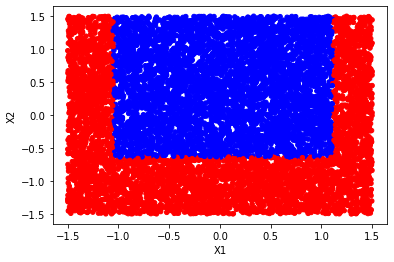

In [287]:
decision_boundary(Dbig_permutation, d32_d3)

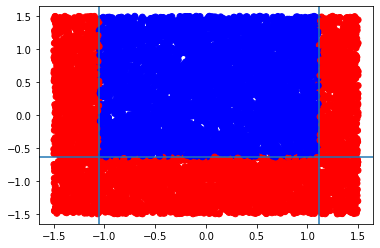

In [337]:
X1_lines, X2_lines = fetch_decision_lines(d32_d3)

plot_decision_boundary(Dbig_permutation, d32_d3, X1_lines, X2_lines)

In [364]:
n.append(get_number_of_nodes(d32_d3))
get_number_of_nodes(d32_d3)

7

In [271]:
global _id
_id = 0
d128_d3 = generate_d3(D128, 'root_d128')

Searching best split candidate for: X1


/var/folders/v0/g401c4x979d___jdl5ddw2_r0000gn/T/ipykernel_36454/1135821344.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  else_positive_count = len(else_dataset[dataset[CLASS_LABEL_COLUMN_NAME] == 1])
/var/folders/v0/g401c4x979d___jdl5ddw2_r0000gn/T/ipykernel_36454/1135821344.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  then_positive_count = len(then_dataset[dataset[CLASS_LABEL_COLUMN_NAME] == 1])


Best X1_split: -1.05255, X1_entropy: 0.8267642634244101, X1_gain_ratio: 0.27677918539276947
Searching best split candidate for: X2
Best X2_split: -0.6965, X2_entropy: 0.7314091418395576, X2_gain_ratio: 0.3477006979775434
X2_gain_ratio > X1_gain_ratio. Choosing X2 as split feature...
Searching best split candidate for: X1
Best X1_split: -1.05255, X1_entropy: 0.6678896537732603, X1_gain_ratio: 0.43526671069473366
Searching best split candidate for: X2
Best X2_split: 1.200903, X2_entropy: 0.7467509994044129, X2_gain_ratio: 0.373303708775358
X1_gain_ratio > X2_gain_ratio. Choosing X1 as split feature...
Searching best split candidate for: X1
Best X1_split: 1.058659, X1_entropy: 0.6345898740265808, X1_gain_ratio: 0.43281454093647226
Searching best split candidate for: X2
Best X2_split: 1.200903, X2_entropy: 0.5068587550466613, X2_gain_ratio: 0.545989030432679
X2_gain_ratio > X1_gain_ratio. Choosing X2 as split feature...
Searching best split candidate for: X1
Best X1_split: 0.714214, X1_ent

In [352]:
printD3(d128_d3)

Level: 0
[Id: 1, predicate: X2 >= -0.6965, parent: root_d128] 
Level: 1
[Id: 2, predicate: X1 >= -1.05255, parent: 1_left] [Id: 17, label: 1, parent: 1_right] 
Level: 2
[Id: 3, predicate: X2 >= 1.200903, parent: 2_left] [Id: 16, label: 1, parent: 2_right] 
Level: 3
[Id: 4, label: 1, parent: 3_left] [Id: 5, predicate: X1 >= 1.11396, parent: 3_right] 
Level: 4
[Id: 6, label: 1, parent: 5_left] [Id: 7, predicate: X2 >= 1.160258, parent: 5_right] 
Level: 5
[Id: 8, predicate: X2 >= 1.184057, parent: 7_left] [Id: 11, predicate: X1 >= -0.642255, parent: 7_right] 
Level: 6
[Id: 9, label: 0, parent: 8_left] [Id: 10, label: 1, parent: 8_right] [Id: 12, label: 0, parent: 11_left] [Id: 13, predicate: X2 >= -0.125335, parent: 11_right] 
Level: 7
[Id: 14, label: 0, parent: 13_left] [Id: 15, label: 1, parent: 13_right] 


In [273]:
fetch_boolean_expressions(d128_d3, [])

X2 >= -0.6965 and X1 >= -1.05255 and X2 >= 1.200903 == 1
X2 >= -0.6965 and X1 >= -1.05255 and !(X2 >= 1.200903) and X1 >= 1.11396 == 1
X2 >= -0.6965 and X1 >= -1.05255 and !(X2 >= 1.200903) and !(X1 >= 1.11396) and X2 >= 1.160258 and X2 >= 1.184057 == 0
X2 >= -0.6965 and X1 >= -1.05255 and !(X2 >= 1.200903) and !(X1 >= 1.11396) and X2 >= 1.160258 and !(X2 >= 1.184057) == 1
X2 >= -0.6965 and X1 >= -1.05255 and !(X2 >= 1.200903) and !(X1 >= 1.11396) and !(X2 >= 1.160258) and X1 >= -0.642255 == 0
X2 >= -0.6965 and X1 >= -1.05255 and !(X2 >= 1.200903) and !(X1 >= 1.11396) and !(X2 >= 1.160258) and !(X1 >= -0.642255) and X2 >= -0.125335 == 0
X2 >= -0.6965 and X1 >= -1.05255 and !(X2 >= 1.200903) and !(X1 >= 1.11396) and !(X2 >= 1.160258) and !(X1 >= -0.642255) and !(X2 >= -0.125335) == 1
X2 >= -0.6965 and !(X1 >= -1.05255) == 1
!(X2 >= -0.6965) == 1


In [367]:
err.append(computeTestError(Dbig_test, d128_d3))
computeTestError(Dbig_test, d128_d3)

0.0702433628318584

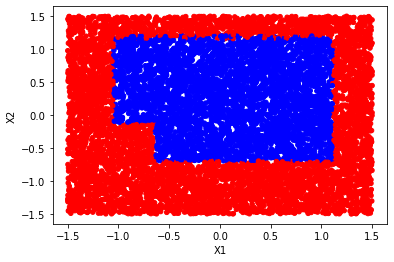

In [288]:
decision_boundary(Dbig_permutation, d128_d3)

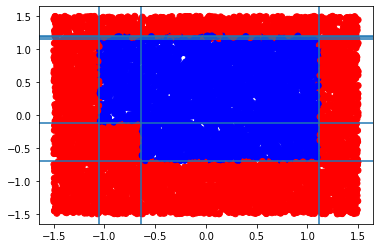

In [338]:
X1_lines, X2_lines = fetch_decision_lines(d128_d3)

plot_decision_boundary(Dbig_permutation, d128_d3, X1_lines, X2_lines)

In [365]:
n.append(get_number_of_nodes(d128_d3))
get_number_of_nodes(d128_d3)

17

In [275]:
global _id
_id = 0
d512_d3 = generate_d3(D512, 'root_d512')

Searching best split candidate for: X1


/var/folders/v0/g401c4x979d___jdl5ddw2_r0000gn/T/ipykernel_36454/1135821344.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  else_positive_count = len(else_dataset[dataset[CLASS_LABEL_COLUMN_NAME] == 1])
/var/folders/v0/g401c4x979d___jdl5ddw2_r0000gn/T/ipykernel_36454/1135821344.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  then_positive_count = len(then_dataset[dataset[CLASS_LABEL_COLUMN_NAME] == 1])


Best X1_split: 1.14174, X1_entropy: 0.8762469837670435, X1_gain_ratio: 0.19876399362351174
Searching best split candidate for: X2
Best X2_split: -0.884844, X2_entropy: 0.821699974430304, X2_gain_ratio: 0.23921529863680085
X2_gain_ratio > X1_gain_ratio. Choosing X2 as split feature...
Searching best split candidate for: X1
Best X1_split: 1.143779, X1_entropy: 0.8567634578442024, X1_gain_ratio: 0.264281307440487
Searching best split candidate for: X2
Best X2_split: 1.221354, X2_entropy: 0.847585305992032, X2_gain_ratio: 0.27133099443843145
X2_gain_ratio > X1_gain_ratio. Choosing X2 as split feature...
Searching best split candidate for: X1
Best X1_split: -1.131859, X1_entropy: 0.0, X1_gain_ratio: 0.0
Searching best split candidate for: X2
Best X2_split: 1.29474, X2_entropy: 0.0, X2_gain_ratio: 0.0
X1 and X2 gain ratio is 0. Finding majority class and stopping
Searching best split candidate for: X1
Best X1_split: 1.143779, X1_entropy: 0.7924885754744057, X1_gain_ratio: 0.3345062219947181


Best X2_split: -0.45904, X2_entropy: 0.2825358588769572, X2_gain_ratio: 0.12927479143524845
X1_gain_ratio > X2_gain_ratio. Choosing X1 as split feature...
Searching best split candidate for: X1
Best X1_split: 1.023874, X1_entropy: 0.3073843731421088, X1_gain_ratio: 0.13844539482994997
Searching best split candidate for: X2
Best X2_split: -0.206705, X2_entropy: 0.21192439057872037, X2_gain_ratio: 0.1445766808739802
X2_gain_ratio > X1_gain_ratio. Choosing X2 as split feature...
Searching best split candidate for: X1
Best X1_split: 1.023874, X1_entropy: 0.012121212121212121, X1_gain_ratio: 0.43618133839030815
Searching best split candidate for: X2
Best X2_split: 0.991623, X2_entropy: 0.033253747280338, X2_gain_ratio: 0.042019832727579066
X1_gain_ratio > X2_gain_ratio. Choosing X1 as split feature...
Searching best split candidate for: X1
Best X1_split: 1.028362, X1_entropy: 0.0, X1_gain_ratio: 1.0
Searching best split candidate for: X2
Best X2_split: 0.991623, X2_entropy: 0.0, X2_gain_rat

Best X2_split: -0.644335, X2_entropy: 0.8631587922386754, X2_gain_ratio: 0.267239482068539
X1_gain_ratio > X2_gain_ratio. Choosing X1 as split feature...
Searching best split candidate for: X1
Best X1_split: -0.237493, X1_entropy: 0.0, X1_gain_ratio: 0
Searching best split candidate for: X2
Best X2_split: -0.668583, X2_entropy: 0.0, X2_gain_ratio: 0.0
X1 and X2 gain ratio is 0. Finding majority class and stopping
Searching best split candidate for: X1
Best X1_split: -0.418624, X1_entropy: 0.1721804688852168, X1_gain_ratio: 0.23715410829179917
Searching best split candidate for: X2
Best X2_split: -0.644335, X2_entropy: 0.0, X2_gain_ratio: 1.0
X2_gain_ratio > X1_gain_ratio. Choosing X2 as split feature...
Searching best split candidate for: X1
Best X1_split: -0.418624, X1_entropy: 0.0, X1_gain_ratio: 0
Searching best split candidate for: X2
Best X2_split: -0.644335, X2_entropy: 0.0, X2_gain_ratio: 0
X1 and X2 gain ratio is 0. Finding majority class and stopping
Searching best split candi

In [353]:
printD3(d512_d3)

Level: 0
[Id: 1, predicate: X2 >= -0.884844, parent: root_d512] 
Level: 1
[Id: 2, predicate: X2 >= 1.221354, parent: 1_left] [Id: 65, label: 1, parent: 1_right] 
Level: 2
[Id: 3, label: 1, parent: 2_left] [Id: 4, predicate: X1 >= 1.143779, parent: 2_right] 
Level: 3
[Id: 5, label: 1, parent: 4_left] [Id: 6, predicate: X1 >= -1.100457, parent: 4_right] 
Level: 4
[Id: 7, predicate: X2 >= -0.637354, parent: 6_left] [Id: 64, label: 1, parent: 6_right] 
Level: 5
[Id: 8, predicate: X1 >= -1.003378, parent: 7_left] [Id: 55, predicate: X2 >= -0.872288, parent: 7_right] 
Level: 6
[Id: 9, predicate: X2 >= 1.138147, parent: 8_left] [Id: 48, predicate: X1 >= -1.076397, parent: 8_right] [Id: 56, predicate: X1 >= 0.24683, parent: 55_left] [Id: 63, label: 0, parent: 55_right] 
Level: 7
[Id: 10, predicate: X2 >= 1.217759, parent: 9_left] [Id: 21, predicate: X1 >= 1.030169, parent: 9_right] [Id: 49, predicate: X2 >= 0.685479, parent: 48_left] [Id: 54, label: 0, parent: 48_right] [Id: 57, label: 1, pare

In [277]:
fetch_boolean_expressions(d512_d3, [])

X2 >= -0.884844 and X2 >= 1.221354 == 1
X2 >= -0.884844 and !(X2 >= 1.221354) and X1 >= 1.143779 == 1
X2 >= -0.884844 and !(X2 >= 1.221354) and !(X1 >= 1.143779) and X1 >= -1.100457 and X2 >= -0.637354 and X1 >= -1.003378 and X2 >= 1.138147 and X2 >= 1.217759 == 0
X2 >= -0.884844 and !(X2 >= 1.221354) and !(X1 >= 1.143779) and X1 >= -1.100457 and X2 >= -0.637354 and X1 >= -1.003378 and X2 >= 1.138147 and !(X2 >= 1.217759) and X1 >= 0.497545 and X2 >= 1.206389 == 1
X2 >= -0.884844 and !(X2 >= 1.221354) and !(X1 >= 1.143779) and X1 >= -1.100457 and X2 >= -0.637354 and X1 >= -1.003378 and X2 >= 1.138147 and !(X2 >= 1.217759) and X1 >= 0.497545 and !(X2 >= 1.206389) == 0
X2 >= -0.884844 and !(X2 >= 1.221354) and !(X1 >= 1.143779) and X1 >= -1.100457 and X2 >= -0.637354 and X1 >= -1.003378 and X2 >= 1.138147 and !(X2 >= 1.217759) and !(X1 >= 0.497545) and X1 >= -0.27626 == 1
X2 >= -0.884844 and !(X2 >= 1.221354) and !(X1 >= 1.143779) and X1 >= -1.100457 and X2 >= -0.637354 and X1 >= -1.0033

In [372]:
err.append(computeTestError(Dbig_test, d512_d3))
computeTestError(Dbig_test, d512_d3)

0.05033185840707965

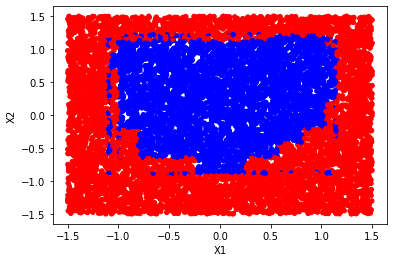

In [289]:
decision_boundary(Dbig_permutation, d512_d3)

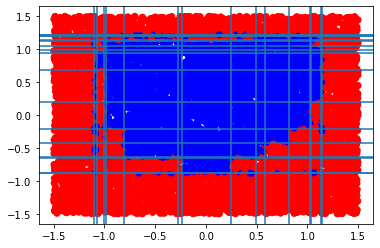

In [339]:
X1_lines, X2_lines = fetch_decision_lines(d512_d3)

plot_decision_boundary(Dbig_permutation, d512_d3, X1_lines, X2_lines)

In [373]:
n.append(get_number_of_nodes(d512_d3))
get_number_of_nodes(d512_d3)

65

In [375]:
n

[7, 17, 65]

In [279]:
global _id
_id = 0
d2048_d3 = generate_d3(D2048, 'root_d2048')

Searching best split candidate for: X1


/var/folders/v0/g401c4x979d___jdl5ddw2_r0000gn/T/ipykernel_36454/1135821344.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  else_positive_count = len(else_dataset[dataset[CLASS_LABEL_COLUMN_NAME] == 1])
/var/folders/v0/g401c4x979d___jdl5ddw2_r0000gn/T/ipykernel_36454/1135821344.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  then_positive_count = len(then_dataset[dataset[CLASS_LABEL_COLUMN_NAME] == 1])


Best X1_split: 1.138735, X1_entropy: 0.8672123642479383, X1_gain_ratio: 0.1900900871007613
Searching best split candidate for: X2
Best X2_split: -0.954911, X2_entropy: 0.8253667546979906, X2_gain_ratio: 0.22096849202668378
X2_gain_ratio > X1_gain_ratio. Choosing X2 as split feature...
Searching best split candidate for: X1
Best X1_split: 1.138735, X1_entropy: 0.8610778863342315, X1_gain_ratio: 0.24912919033562522
Searching best split candidate for: X2
Best X2_split: 1.234938, X2_entropy: 0.8811494880200538, X2_gain_ratio: 0.23366583875825733
X1_gain_ratio > X2_gain_ratio. Choosing X1 as split feature...
Searching best split candidate for: X1
Best X1_split: 1.400477, X1_entropy: 0.0, X1_gain_ratio: 0.0
Searching best split candidate for: X2
Best X2_split: 0.053226, X2_entropy: 0.0, X2_gain_ratio: 0.0
X1 and X2 gain ratio is 0. Finding majority class and stopping
Searching best split candidate for: X1
Best X1_split: -1.138432, X1_entropy: 0.8208750106148058, X1_gain_ratio: 0.306434133980

Best X1_split: -0.27626, X1_entropy: 0.0, X1_gain_ratio: 0
Searching best split candidate for: X2
Best X2_split: 1.200903, X2_entropy: 0.0, X2_gain_ratio: 0.0
X1 and X2 gain ratio is 0. Finding majority class and stopping
Searching best split candidate for: X1
Best X1_split: -0.567575, X1_entropy: 0.0, X1_gain_ratio: 0
Searching best split candidate for: X2
Best X2_split: 1.209165, X2_entropy: 0.0, X2_gain_ratio: 0
X1 and X2 gain ratio is 0. Finding majority class and stopping
Searching best split candidate for: X1
Best X1_split: -0.906487, X1_entropy: 0.3793300146916652, X1_gain_ratio: 0.179454255312929
Searching best split candidate for: X2
Best X2_split: 1.138147, X2_entropy: 0.43055063664632626, X2_gain_ratio: 0.1016337251396713
X1_gain_ratio > X2_gain_ratio. Choosing X1 as split feature...
Searching best split candidate for: X1
Best X1_split: 0.980188, X1_entropy: 0.26957333750933626, X1_gain_ratio: 0.24882072519115275
Searching best split candidate for: X2
Best X2_split: 1.137006

Best X2_split: -0.192209, X2_entropy: 0.07545856045507715, X2_gain_ratio: 0.07762373231397121
X2_gain_ratio > X1_gain_ratio. Choosing X2 as split feature...
Searching best split candidate for: X1
Best X1_split: -0.470132, X1_entropy: 0.0, X1_gain_ratio: 0.0
Searching best split candidate for: X2
Best X2_split: 0.146419, X2_entropy: 0.0, X2_gain_ratio: 0.0
X1 and X2 gain ratio is 0. Finding majority class and stopping
Searching best split candidate for: X1
Best X1_split: 0.796035, X1_entropy: 0.18837928032239332, X1_gain_ratio: 0.669435988663247
Searching best split candidate for: X2
Best X2_split: -0.192251, X2_entropy: 0.47383857759631015, X2_gain_ratio: 0.3994465308173805
X1_gain_ratio > X2_gain_ratio. Choosing X1 as split feature...
Searching best split candidate for: X1
Best X1_split: 0.844093, X1_entropy: 0.32451124978365314, X1_gain_ratio: 0.14880710164946886
Searching best split candidate for: X2
Best X2_split: -0.208818, X2_entropy: 0.2, X2_gain_ratio: 0.3726071827572396
X2_gai

Best X1_split: -1.120893, X1_entropy: 0.3443609377704336, X1_gain_ratio: 0.20871375581620352
Searching best split candidate for: X2
Best X2_split: 0.859853, X2_entropy: 0.4056390622295664, X2_gain_ratio: 0.13792538097003
X1_gain_ratio > X2_gain_ratio. Choosing X1 as split feature...
Searching best split candidate for: X1
Best X1_split: -1.108515, X1_entropy: 0.0, X1_gain_ratio: 0.0
Searching best split candidate for: X2
Best X2_split: 0.877795, X2_entropy: 0.0, X2_gain_ratio: 0.0
X1 and X2 gain ratio is 0. Finding majority class and stopping
Searching best split candidate for: X1
Best X1_split: -1.127253, X1_entropy: 0.0, X1_gain_ratio: 1.0
Searching best split candidate for: X2
Best X2_split: 0.399687, X2_entropy: 0.6666666666666666, X2_gain_ratio: 0.274017542121281
X1_gain_ratio > X2_gain_ratio. Choosing X1 as split feature...
Searching best split candidate for: X1
Best X1_split: -1.127253, X1_entropy: 0.0, X1_gain_ratio: 0
Searching best split candidate for: X2
Best X2_split: 0.3996

Best X2_split: -0.665368, X2_entropy: 0.0, X2_gain_ratio: 0
X1 and X2 gain ratio is 0. Finding majority class and stopping
Searching best split candidate for: X1
Best X1_split: -0.273334, X1_entropy: 0.0, X1_gain_ratio: 0.0
Searching best split candidate for: X2
Best X2_split: -0.885239, X2_entropy: 0.0, X2_gain_ratio: 0.0
X1 and X2 gain ratio is 0. Finding majority class and stopping
Searching best split candidate for: X1
Best X1_split: -0.67619, X1_entropy: 0.0, X1_gain_ratio: 0.0
Searching best split candidate for: X2
Best X2_split: -0.663384, X2_entropy: 0.0, X2_gain_ratio: 0.0
X1 and X2 gain ratio is 0. Finding majority class and stopping
Searching best split candidate for: X1
Best X1_split: -1.430294, X1_entropy: 0.0, X1_gain_ratio: 0.0
Searching best split candidate for: X2
Best X2_split: -0.562824, X2_entropy: 0.0, X2_gain_ratio: 0.0
X1 and X2 gain ratio is 0. Finding majority class and stopping
Searching best split candidate for: X1
Best X1_split: -0.699877, X1_entropy: 0.0, X

In [354]:
printD3(d2048_d3)

Level: 0
[Id: 1, predicate: X2 >= -0.954911, parent: root_d2048] 
Level: 1
[Id: 2, predicate: X1 >= 1.138735, parent: 1_left] [Id: 121, label: 1, parent: 1_right] 
Level: 2
[Id: 3, label: 1, parent: 2_left] [Id: 4, predicate: X1 >= -1.138432, parent: 2_right] 
Level: 3
[Id: 5, predicate: X2 >= 1.234938, parent: 4_left] [Id: 120, label: 1, parent: 4_right] 
Level: 4
[Id: 6, label: 1, parent: 5_left] [Id: 7, predicate: X2 >= -0.447016, parent: 5_right] 
Level: 5
[Id: 8, predicate: X1 >= 1.048605, parent: 7_left] [Id: 93, predicate: X1 >= -0.44684, parent: 7_right] 
Level: 6
[Id: 9, predicate: X1 >= 1.135738, parent: 8_left] [Id: 16, predicate: X1 >= -1.102858, parent: 8_right] [Id: 94, predicate: X1 >= 0.323371, parent: 93_left] [Id: 119, label: 1, parent: 93_right] 
Level: 7
[Id: 10, label: 0, parent: 9_left] [Id: 11, predicate: X2 >= 0.34806, parent: 9_right] [Id: 17, predicate: X2 >= 1.199003, parent: 16_left] [Id: 86, predicate: X1 >= -1.135491, parent: 16_right] [Id: 95, predicate: 

In [281]:
fetch_boolean_expressions(d2048_d3, [])

X2 >= -0.954911 and X1 >= 1.138735 == 1
X2 >= -0.954911 and !(X1 >= 1.138735) and X1 >= -1.138432 and X2 >= 1.234938 == 1
X2 >= -0.954911 and !(X1 >= 1.138735) and X1 >= -1.138432 and !(X2 >= 1.234938) and X2 >= -0.447016 and X1 >= 1.048605 and X1 >= 1.135738 == 0
X2 >= -0.954911 and !(X1 >= 1.138735) and X1 >= -1.138432 and !(X2 >= 1.234938) and X2 >= -0.447016 and X1 >= 1.048605 and !(X1 >= 1.135738) and X2 >= 0.34806 and X2 >= 0.881911 == 1
X2 >= -0.954911 and !(X1 >= 1.138735) and X1 >= -1.138432 and !(X2 >= 1.234938) and X2 >= -0.447016 and X1 >= 1.048605 and !(X1 >= 1.135738) and X2 >= 0.34806 and !(X2 >= 0.881911) == 0
X2 >= -0.954911 and !(X1 >= 1.138735) and X1 >= -1.138432 and !(X2 >= 1.234938) and X2 >= -0.447016 and X1 >= 1.048605 and !(X1 >= 1.135738) and !(X2 >= 0.34806) == 1
X2 >= -0.954911 and !(X1 >= 1.138735) and X1 >= -1.138432 and !(X2 >= 1.234938) and X2 >= -0.447016 and !(X1 >= 1.048605) and X1 >= -1.102858 and X2 >= 1.199003 and X2 >= 1.23018 == 0
X2 >= -0.954911

In [376]:
err.append(computeTestError(Dbig_test, d2048_d3))
computeTestError(Dbig_test, d2048_d3)

0.03761061946902655

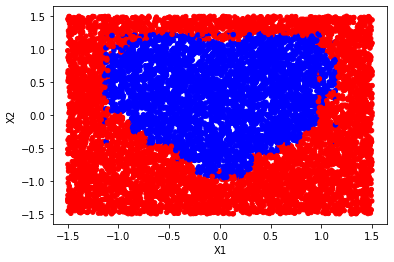

In [290]:
decision_boundary(Dbig_permutation, d2048_d3)

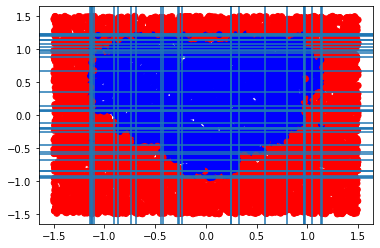

In [340]:
X1_lines, X2_lines = fetch_decision_lines(d2048_d3)

plot_decision_boundary(Dbig_permutation, d2048_d3, X1_lines, X2_lines)

In [377]:
n.append(get_number_of_nodes(d2048_d3))
get_number_of_nodes(d2048_d3)

121

In [379]:
err

[0.14767699115044247,
 0.0702433628318584,
 0.05033185840707965,
 0.03761061946902655]

In [283]:
global _id
_id = 0
d8192_d3 = generate_d3(D8192, 'root_d8192')

Searching best split candidate for: X1


/var/folders/v0/g401c4x979d___jdl5ddw2_r0000gn/T/ipykernel_36454/1135821344.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  else_positive_count = len(else_dataset[dataset[CLASS_LABEL_COLUMN_NAME] == 1])
/var/folders/v0/g401c4x979d___jdl5ddw2_r0000gn/T/ipykernel_36454/1135821344.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  then_positive_count = len(then_dataset[dataset[CLASS_LABEL_COLUMN_NAME] == 1])


Best X1_split: 1.135791, X1_entropy: 0.8746392856883628, X1_gain_ratio: 0.1821331506875678
Searching best split candidate for: X2
Best X2_split: -0.926187, X2_entropy: 0.807960249646067, X2_gain_ratio: 0.23030744710613865
X2_gain_ratio > X1_gain_ratio. Choosing X2 as split feature...
Searching best split candidate for: X1
Best X1_split: 1.135791, X1_entropy: 0.8666462456142848, X1_gain_ratio: 0.24855758479083606
Searching best split candidate for: X2
Best X2_split: 1.232245, X2_entropy: 0.8733482119035525, X2_gain_ratio: 0.24337922046885407
X1_gain_ratio > X2_gain_ratio. Choosing X1 as split feature...
Searching best split candidate for: X1
Best X1_split: 1.400477, X1_entropy: 0.0, X1_gain_ratio: 0.0
Searching best split candidate for: X2
Best X2_split: 0.053226, X2_entropy: 0.0, X2_gain_ratio: 0.0
X1 and X2 gain ratio is 0. Finding majority class and stopping
Searching best split candidate for: X1
Best X1_split: -1.128693, X1_entropy: 0.7990366898973381, X1_gain_ratio: 0.3223804439816

Best X1_split: 0.384608, X1_entropy: 0.6204869460326022, X1_gain_ratio: 0.47241724424807985
Searching best split candidate for: X2
Best X2_split: 1.227066, X2_entropy: 0.8925768472426706, X2_gain_ratio: 0.1285155090335475
X1_gain_ratio > X2_gain_ratio. Choosing X1 as split feature...
Searching best split candidate for: X1
Best X1_split: 0.481915, X1_entropy: 0.0, X1_gain_ratio: 0.0
Searching best split candidate for: X2
Best X2_split: 1.217759, X2_entropy: 0.0, X2_gain_ratio: 0.0
X1 and X2 gain ratio is 0. Finding majority class and stopping
Searching best split candidate for: X1
Best X1_split: -0.291223, X1_entropy: 0.4938462544479017, X1_gain_ratio: 0.2615291581135271
Searching best split candidate for: X2
Best X2_split: 1.204421, X2_entropy: 0.6670997050300268, X2_gain_ratio: 0.11686335835589994
X1_gain_ratio > X2_gain_ratio. Choosing X1 as split feature...
Searching best split candidate for: X1
Best X1_split: -0.27626, X1_entropy: 0.0, X1_gain_ratio: 0.0
Searching best split candid

Best X2_split: 1.160361, X2_entropy: 0.9562263881013594, X2_gain_ratio: 0.1723404672890585
X1_gain_ratio > X2_gain_ratio. Choosing X1 as split feature...
Searching best split candidate for: X1
Best X1_split: 0.819043, X1_entropy: 0.0, X1_gain_ratio: 0.0
Searching best split candidate for: X2
Best X2_split: 1.17414, X2_entropy: 0.0, X2_gain_ratio: 0.0
X1 and X2 gain ratio is 0. Finding majority class and stopping
Searching best split candidate for: X1
Best X1_split: -0.751347, X1_entropy: 0.7492305151711947, X1_gain_ratio: 0.3699469912240571
Searching best split candidate for: X2
Best X2_split: 1.160361, X2_entropy: 0.904589926083527, X2_gain_ratio: 0.20852787878378318
X1_gain_ratio > X2_gain_ratio. Choosing X1 as split feature...
Searching best split candidate for: X1
Best X1_split: -0.234924, X1_entropy: 0.6085184774986196, X1_gain_ratio: 0.23753772039337798
Searching best split candidate for: X2
Best X2_split: 1.160361, X2_entropy: 0.8042931626363296, X2_gain_ratio: 0.264511872279232

Best X1_split: 0.968073, X1_entropy: 0.0, X1_gain_ratio: 0.0
Searching best split candidate for: X2
Best X2_split: -0.268507, X2_entropy: 0.0, X2_gain_ratio: 0.0
X1 and X2 gain ratio is 0. Finding majority class and stopping
Searching best split candidate for: X1
Best X1_split: -0.868695, X1_entropy: 0.13137051662834964, X1_gain_ratio: 0.08206355922846142
Searching best split candidate for: X2
Best X2_split: 1.150909, X2_entropy: 0.14078482218449206, X2_gain_ratio: 0.04777558694091629
X1_gain_ratio > X2_gain_ratio. Choosing X1 as split feature...
Searching best split candidate for: X1
Best X1_split: 0.795968, X1_entropy: 0.11145823790648343, X1_gain_ratio: 0.016981009071877943
Searching best split candidate for: X2
Best X2_split: 1.150909, X2_entropy: 0.11406296147786717, X2_gain_ratio: 0.037584289300521545
X2_gain_ratio > X1_gain_ratio. Choosing X2 as split feature...
Searching best split candidate for: X1
Best X1_split: 0.272758, X1_entropy: 0.46494301514234015, X1_gain_ratio: 0.1459

Best X1_split: -0.069009, X1_entropy: 0.0, X1_gain_ratio: 0.0
Searching best split candidate for: X2
Best X2_split: 1.073586, X2_entropy: 0.0, X2_gain_ratio: 0.0
X1 and X2 gain ratio is 0. Finding majority class and stopping
Searching best split candidate for: X1
Best X1_split: -0.634468, X1_entropy: 0.0, X1_gain_ratio: 0.0
Searching best split candidate for: X2
Best X2_split: 1.135451, X2_entropy: 0.0, X2_gain_ratio: 0.0
X1 and X2 gain ratio is 0. Finding majority class and stopping
Searching best split candidate for: X1
Best X1_split: 0.017623, X1_entropy: 0.0, X1_gain_ratio: 0
Searching best split candidate for: X2
Best X2_split: 1.038738, X2_entropy: 0.0, X2_gain_ratio: 0
X1 and X2 gain ratio is 0. Finding majority class and stopping
Searching best split candidate for: X1
Best X1_split: 0.851342, X1_entropy: 0.0033535618588435706, X1_gain_ratio: 0.0177075792187473
Searching best split candidate for: X2
Best X2_split: -0.248085, X2_entropy: 0.0033214021790995063, X2_gain_ratio: 0.01

Best X2_split: -0.212531, X2_entropy: 0.0, X2_gain_ratio: 0.0
X1 and X2 gain ratio is 0. Finding majority class and stopping
Searching best split candidate for: X1
Best X1_split: -0.680578, X1_entropy: 0.5117639783319679, X1_gain_ratio: 0.5522839216305567
Searching best split candidate for: X2
Best X2_split: -0.421942, X2_entropy: 0.8380915457962694, X2_gain_ratio: 0.2150812309090347
X1_gain_ratio > X2_gain_ratio. Choosing X1 as split feature...
Searching best split candidate for: X1
Best X1_split: 0.684929, X1_entropy: 0.11220296730805512, X1_gain_ratio: 0.8728419164827033
Searching best split candidate for: X2
Best X2_split: -0.427031, X2_entropy: 0.5975944190747181, X2_gain_ratio: 0.033977392219073324
X1_gain_ratio > X2_gain_ratio. Choosing X1 as split feature...
Searching best split candidate for: X1
Best X1_split: 0.895582, X1_entropy: 0.0, X1_gain_ratio: 0.0
Searching best split candidate for: X2
Best X2_split: -0.459589, X2_entropy: 0.0, X2_gain_ratio: 0.0
X1 and X2 gain ratio i

Best X2_split: 1.040026, X2_entropy: 0.0, X2_gain_ratio: 0.0
X1 and X2 gain ratio is 0. Finding majority class and stopping
Searching best split candidate for: X1
Best X1_split: -1.012672, X1_entropy: 0.36154961106231986, X1_gain_ratio: 0.04189462820388134
Searching best split candidate for: X2
Best X2_split: 0.022087, X2_entropy: 0.24836953932731967, X2_gain_ratio: 0.4363255301445457
X2_gain_ratio > X1_gain_ratio. Choosing X2 as split feature...
Searching best split candidate for: X1
Best X1_split: -1.059672, X1_entropy: 0.1480584894521332, X1_gain_ratio: 0.07300841701416767
Searching best split candidate for: X2
Best X2_split: 0.906693, X2_entropy: 0.15480278183348184, X2_gain_ratio: 0.2657887833721602
X2_gain_ratio > X1_gain_ratio. Choosing X2 as split feature...
Searching best split candidate for: X1
Best X1_split: -1.045722, X1_entropy: 0.0, X1_gain_ratio: 1.0
Searching best split candidate for: X2
Best X2_split: 0.910656, X2_entropy: 0.0, X2_gain_ratio: 1.0
X2_gain_ratio > X1_gai

Best X2_split: -0.561203, X2_entropy: 0.0, X2_gain_ratio: 1.0
X2_gain_ratio > X1_gain_ratio. Choosing X2 as split feature...
Searching best split candidate for: X1
Best X1_split: 0.542348, X1_entropy: 0.0, X1_gain_ratio: 0
Searching best split candidate for: X2
Best X2_split: -0.547072, X2_entropy: 0.0, X2_gain_ratio: 0.0
X1 and X2 gain ratio is 0. Finding majority class and stopping
Searching best split candidate for: X1
Best X1_split: 0.543269, X1_entropy: 0.0, X1_gain_ratio: 0.0
Searching best split candidate for: X2
Best X2_split: -0.629486, X2_entropy: 0.0, X2_gain_ratio: 0.0
X1 and X2 gain ratio is 0. Finding majority class and stopping
Searching best split candidate for: X1
Best X1_split: -0.461223, X1_entropy: 0.22075137341347503, X1_gain_ratio: 0.23301259705529062
Searching best split candidate for: X2
Best X2_split: -0.648231, X2_entropy: 0.2050051678772262, X2_gain_ratio: 0.08045398624063284
X1_gain_ratio > X2_gain_ratio. Choosing X1 as split feature...
Searching best split 

Best X1_split: -1.127253, X1_entropy: 0.0, X1_gain_ratio: 0.0
Searching best split candidate for: X2
Best X2_split: 0.399687, X2_entropy: 0.0, X2_gain_ratio: 0
X1 and X2 gain ratio is 0. Finding majority class and stopping
Searching best split candidate for: X1
Best X1_split: 0.332107, X1_entropy: 0.5510260726811104, X1_gain_ratio: 0.14508583375968592
Searching best split candidate for: X2
Best X2_split: -0.925588, X2_entropy: 0.6718592634339834, X2_gain_ratio: 0.28487048478765314
X2_gain_ratio > X1_gain_ratio. Choosing X2 as split feature...
Searching best split candidate for: X1
Best X1_split: 0.332107, X1_entropy: 0.5425263560082051, X1_gain_ratio: 0.14106555213189814
Searching best split candidate for: X2
Best X2_split: -0.712734, X2_entropy: 0.6744829122767277, X2_gain_ratio: 0.03290534524746529
X1_gain_ratio > X2_gain_ratio. Choosing X1 as split feature...
Searching best split candidate for: X1
Best X1_split: 0.661876, X1_entropy: 0.0, X1_gain_ratio: 0.0
Searching best split cand

Best X1_split: 0.158802, X1_entropy: 0.0, X1_gain_ratio: 0
Searching best split candidate for: X2
Best X2_split: -0.925227, X2_entropy: 0.0, X2_gain_ratio: 0
X1 and X2 gain ratio is 0. Finding majority class and stopping
Searching best split candidate for: X1
Best X1_split: -0.330695, X1_entropy: 0.04962854395043571, X1_gain_ratio: 0.08577958719148214
Searching best split candidate for: X2
Best X2_split: -0.712842, X2_entropy: 0.06779267480902423, X2_gain_ratio: 0.13392939182450816
X2_gain_ratio > X1_gain_ratio. Choosing X2 as split feature...
Searching best split candidate for: X1
Best X1_split: -0.330695, X1_entropy: 0.0, X1_gain_ratio: 1.0
Searching best split candidate for: X2
Best X2_split: -0.712734, X2_entropy: 0.0, X2_gain_ratio: 1.0
X2_gain_ratio > X1_gain_ratio. Choosing X2 as split feature...
Searching best split candidate for: X1
Best X1_split: -0.674065, X1_entropy: 0.0, X1_gain_ratio: 0.0
Searching best split candidate for: X2
Best X2_split: -0.712734, X2_entropy: 0.0, X2

In [355]:
printD3(d8192_d3)

Level: 0
[Id: 1, predicate: X2 >= -0.926187, parent: root_d8192] 
Level: 1
[Id: 2, predicate: X1 >= 1.135791, parent: 1_left] [Id: 277, predicate: X2 >= -0.954911, parent: 1_right] 
Level: 2
[Id: 3, label: 1, parent: 2_left] [Id: 4, predicate: X1 >= -1.128693, parent: 2_right] [Id: 278, predicate: X2 >= -0.954629, parent: 277_left] [Id: 281, label: 1, parent: 277_right] 
Level: 3
[Id: 5, predicate: X2 >= 1.232245, parent: 4_left] [Id: 272, predicate: X1 >= -1.138432, parent: 4_right] [Id: 279, label: 1, parent: 278_left] [Id: 280, label: 0, parent: 278_right] 
Level: 4
[Id: 6, label: 1, parent: 5_left] [Id: 7, predicate: X2 >= -0.711517, parent: 5_right] [Id: 273, predicate: X1 >= -1.138188, parent: 272_left] [Id: 276, label: 1, parent: 272_right] 
Level: 5
[Id: 8, predicate: X1 >= 1.061254, parent: 7_left] [Id: 233, predicate: X2 >= -0.925588, parent: 7_right] [Id: 274, label: 1, parent: 273_left] [Id: 275, label: 0, parent: 273_right] 
Level: 6
[Id: 9, predicate: X1 >= 1.135738, pare

In [285]:
fetch_boolean_expressions(d8192_d3, [])

X2 >= -0.926187 and X1 >= 1.135791 == 1
X2 >= -0.926187 and !(X1 >= 1.135791) and X1 >= -1.128693 and X2 >= 1.232245 == 1
X2 >= -0.926187 and !(X1 >= 1.135791) and X1 >= -1.128693 and !(X2 >= 1.232245) and X2 >= -0.711517 and X1 >= 1.061254 and X1 >= 1.135738 == 0
X2 >= -0.926187 and !(X1 >= 1.135791) and X1 >= -1.128693 and !(X2 >= 1.232245) and X2 >= -0.711517 and X1 >= 1.061254 and !(X1 >= 1.135738) and X2 >= 0.165721 and X2 >= 0.786355 == 1
X2 >= -0.926187 and !(X1 >= 1.135791) and X1 >= -1.128693 and !(X2 >= 1.232245) and X2 >= -0.711517 and X1 >= 1.061254 and !(X1 >= 1.135738) and X2 >= 0.165721 and !(X2 >= 0.786355) and X1 >= 1.135402 == 1
X2 >= -0.926187 and !(X1 >= 1.135791) and X1 >= -1.128693 and !(X2 >= 1.232245) and X2 >= -0.711517 and X1 >= 1.061254 and !(X1 >= 1.135738) and X2 >= 0.165721 and !(X2 >= 0.786355) and !(X1 >= 1.135402) and X2 >= 0.344536 == 0
X2 >= -0.926187 and !(X1 >= 1.135791) and X1 >= -1.128693 and !(X2 >= 1.232245) and X2 >= -0.711517 and X1 >= 1.06125

In [380]:
err.append(computeTestError(Dbig_test, d8192_d3))
err

[0.14767699115044247,
 0.0702433628318584,
 0.05033185840707965,
 0.03761061946902655,
 0.016592920353982302]

In [381]:
n.append(get_number_of_nodes(d8192_d3))
n

[7, 17, 65, 121, 281]

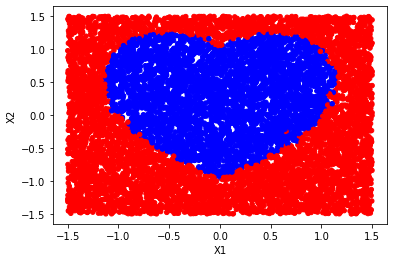

In [291]:
decision_boundary(Dbig_permutation, d8192_d3)

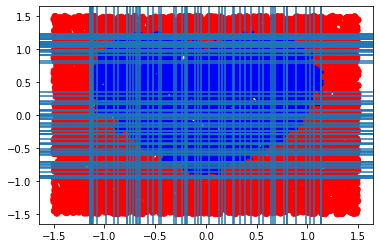

In [341]:
X1_lines, X2_lines = fetch_decision_lines(d8192_d3)

plot_decision_boundary(Dbig_permutation, d8192_d3, X1_lines, X2_lines)

In [382]:
# number of nodes in D32, D128, D512, D2048, D8192
n

[7, 17, 65, 121, 281]

In [383]:
# classification error on test set 
err

[0.14767699115044247,
 0.0702433628318584,
 0.05033185840707965,
 0.03761061946902655,
 0.016592920353982302]

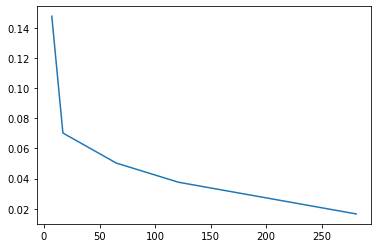

In [384]:
# n vs err
plt.plot(n, err)

In [ ]:
# DEBUGGING

In [ ]:
data = [[1,0],[1,0],[1,1],[1,1],[0,1],[0,0],[0,1],[1,0],[0,1],[0,1],[0,1],[1,1],[0,1],[1,0]]

In [ ]:
df = pd.DataFrame(data, columns=['feature','Y'])

In [ ]:
df

In [ ]:
calculateConditionalEntropy(df, 'feature', 1)

In [ ]:
calculate_conditional_entropy(D1_dataset, FEATURE_2, 0.201829)